Task | Duration | EST | EFT | LST | LFT | TF | FF
-----|----------|-----|-----|-----|-----|----|----
1    |        0 |   0 |   0 |   0 |   0 |  0 |  0
2    |        8 |   0 |   8 |   0 |   8 |  0 |  0
4    |       12 |   8 |  20 |   8 |  20 |  0 |  0
6    |        6 |  20 |  26 |  20 |  26 |  0 |  0
3    |        4 |   8 |  12 |   8 |  12 |  0 |  0
5    |        5 |  12 |  17 |  12 |  17 |  0 |  0
8    |        6 |  17 |  23 |  17 |  23 |  0 |  0
7    |        6 |  17 |  23 |  17 |  23 |  0 |  0
9    |        5 |  23 |  28 |  23 |  28 |  0 |  0
10   |       10 |  28 |  38 |  28 |  38 |  0 |  0

Critical Path: 1 - 2 - 3 - 5 - 7 - 9 - 10 with total duration 41


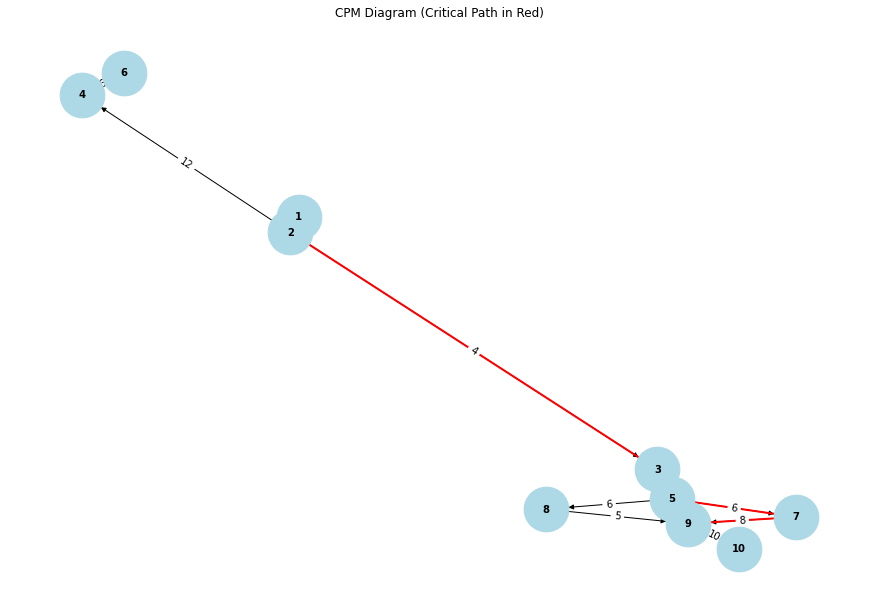

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Calculate EST, EFT, LST, LFT, TF, FF
def calculate_times(graph):
    # Step 1: Calculate EST and EFT (forward pass)
    est = {}
    eft = {}
    
    # We need to know task durations - we'll assume duration is the weight of incoming edges
    # For the start node (with no incoming edges), we'll assume duration 0
    durations = {node: 0 for node in graph.nodes}
    for u, v, data in graph.edges(data=True):
        durations[v] = data['weight']  # Assuming duration is the weight from any incoming edge
    
    for node in nx.topological_sort(graph):
        if not list(graph.predecessors(node)):  # Start node
            est[node] = 0
        else:
            est[node] = max([est[dep] + durations[dep] for dep in graph.predecessors(node)], default=0)
        eft[node] = est[node] + durations[node]
    
    # Step 2: Calculate LST and LFT (backward pass)
    lft = {}
    lst = {}
    
    # Initialize with the end node(s)
    end_nodes = [node for node in graph.nodes if not list(graph.successors(node))]
    for node in end_nodes:
        lft[node] = eft[node]
        lst[node] = lft[node] - durations[node]
    
    for node in reversed(list(nx.topological_sort(graph))):
        if node not in lft:
            # For non-end nodes, LFT is min of LST of successors
            lft[node] = min([lst[succ] for succ in graph.successors(node)], default=eft[node])
        lst[node] = lft[node] - durations[node]
    
    # Step 3: Calculate TF and FF
    tf = {node: lst[node] - est[node] for node in graph.nodes}
    ff = {}
    for node in graph.nodes:
        if not list(graph.successors(node)):  # End node
            ff[node] = 0
        else:
            ff[node] = min([est[succ] - eft[node] for succ in graph.successors(node)], default=0)
    
    return est, eft, lst, lft, tf, ff, durations

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.spring_layout(graph, seed=42)  # Fixed seed for consistent layout
    plt.figure(figsize=(12, 8))
    
    # Draw nodes and edges
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    
    # Add edge labels (weights)
    edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Highlight the critical path in red
    critical_path, _ = find_critical_path(graph)
    critical_edges = list(zip(critical_path, critical_path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=critical_edges, edge_color='red', width=2)
    
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Main Program
event_data = {
    '1': {},  # Start node with no dependencies
    '2': {'1': 8},
    '3': {'2': 4},
    '4': {'2': 12},
    '5': {'3': 5},
    '6': {'4': 6},
    '7': {'5': 6},
    '8': {'5': 6},
    '9': {'7': 8, '8': 5},
    '10': {'9': 10}
}

# Create the project graph from event data
graph = create_dynamic_events(event_data)

# Calculate the EST, EFT, LST, LFT, TF, FF for each task
est, eft, lst, lft, tf, ff, durations = calculate_times(graph)

# Display the results in a readable format
print("Task | Duration | EST | EFT | LST | LFT | TF | FF")
print("-----|----------|-----|-----|-----|-----|----|----")
for node in nx.topological_sort(graph):
    print(f"{node:4} | {durations[node]:8} | {est[node]:3} | {eft[node]:3} | {lst[node]:3} | {lft[node]:3} | {tf[node]:2} | {ff[node]:2}")

# Find and display the critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {' - '.join(critical_path)} with total duration {length}")

# Visualize the graph with the critical path highlighted
visualize_graph(graph)

Task | Duration | EST | EFT | LST | LFT | TF | FF
-----|----------|-----|-----|-----|-----|----|----
1    |        0 |   0 |   0 |   0 |   0 |  0 |  0
3    |        4 |   0 |   4 |   2 |   6 |  2 |  0
4    |        2 |   4 |   6 |   6 |   8 |  2 |  0
5    |       15 |   6 |  21 |   8 |  23 |  2 |  0
6    |        4 |  21 |  25 |  23 |  27 |  2 |  0
7    |        9 |  25 |  34 |  27 |  36 |  2 |  2
2    |       36 |   0 |  36 |   0 |  36 |  0 |  0
8    |        9 |  36 |  45 |  36 |  45 |  0 |  0
9    |       20 |  45 |  65 |  45 |  65 |  0 |  0
10   |       20 |  65 |  85 |  65 |  85 |  0 |  0

Critical Path: 1 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 with total duration 83


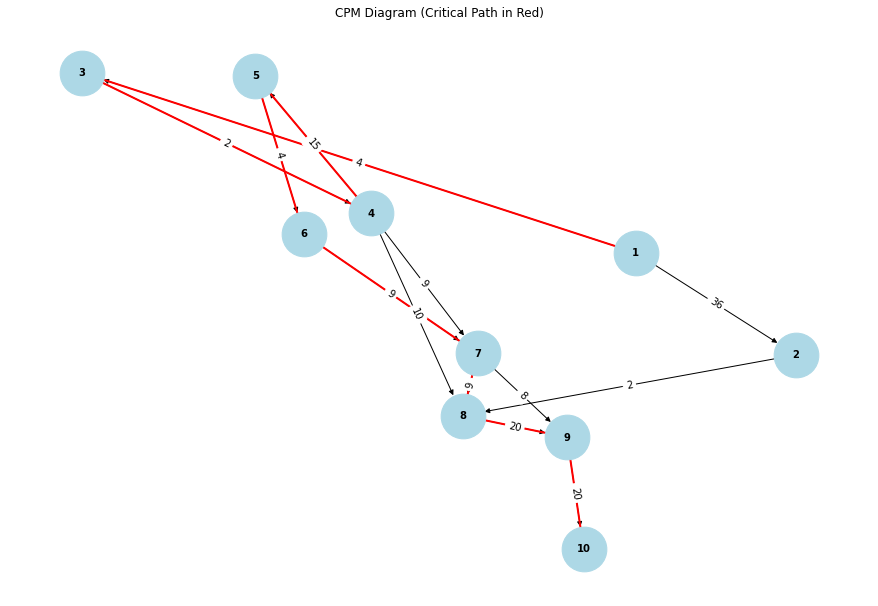

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Calculate EST, EFT, LST, LFT, TF, FF
def calculate_times(graph):
    # Step 1: Calculate EST and EFT (forward pass)
    est = {}
    eft = {}
    
    # We need to know task durations - we'll assume duration is the weight of incoming edges
    # For the start node (with no incoming edges), we'll assume duration 0
    durations = {node: 0 for node in graph.nodes}
    for u, v, data in graph.edges(data=True):
        durations[v] = data['weight']  # Assuming duration is the weight from any incoming edge
    
    for node in nx.topological_sort(graph):
        if not list(graph.predecessors(node)):  # Start node
            est[node] = 0
        else:
            est[node] = max([est[dep] + durations[dep] for dep in graph.predecessors(node)], default=0)
        eft[node] = est[node] + durations[node]
    
    # Step 2: Calculate LST and LFT (backward pass)
    lft = {}
    lst = {}
    
    # Initialize with the end node(s)
    end_nodes = [node for node in graph.nodes if not list(graph.successors(node))]
    for node in end_nodes:
        lft[node] = eft[node]
        lst[node] = lft[node] - durations[node]
    
    for node in reversed(list(nx.topological_sort(graph))):
        if node not in lft:
            # For non-end nodes, LFT is min of LST of successors
            lft[node] = min([lst[succ] for succ in graph.successors(node)], default=eft[node])
        lst[node] = lft[node] - durations[node]
    
    # Step 3: Calculate TF and FF
    tf = {node: lst[node] - est[node] for node in graph.nodes}
    ff = {}
    for node in graph.nodes:
        if not list(graph.successors(node)):  # End node
            ff[node] = 0
        else:
            ff[node] = min([est[succ] - eft[node] for succ in graph.successors(node)], default=0)
    
    return est, eft, lst, lft, tf, ff, durations

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.spring_layout(graph, seed=42)  # Fixed seed for consistent layout
    plt.figure(figsize=(12, 8))
    
    # Draw nodes and edges
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    
    # Add edge labels (weights)
    edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Highlight the critical path in red
    critical_path, _ = find_critical_path(graph)
    critical_edges = list(zip(critical_path, critical_path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=critical_edges, edge_color='red', width=2)
    
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Main Program
event_data = {
    '1': {},  # Start node with no dependencies
    '2': {'1': 36},
    '3': {'1': 4},
    '4': {'3': 2},
    '5': {'4': 15},
    '6': {'5': 4},
    '7': {'6': 9,'4':9},
    '8': {'2': 2,'4':10,'7':9},
    '9': {'7': 8,'8':20},
    '10': {'9': 20}

}

# Create the project graph from event data
graph = create_dynamic_events(event_data)

# Calculate the EST, EFT, LST, LFT, TF, FF for each task
est, eft, lst, lft, tf, ff, durations = calculate_times(graph)

# Display the results in a readable format
print("Task | Duration | EST | EFT | LST | LFT | TF | FF")
print("-----|----------|-----|-----|-----|-----|----|----")
for node in nx.topological_sort(graph):
    print(f"{node:4} | {durations[node]:8} | {est[node]:3} | {eft[node]:3} | {lst[node]:3} | {lft[node]:3} | {tf[node]:2} | {ff[node]:2}")

# Find and display the critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {' - '.join(critical_path)} with total duration {length}")

# Visualize the graph with the critical path highlighted
visualize_graph(graph)
